<a href="https://colab.research.google.com/github/fdeloscogna/Python_experiment/blob/main/Tesi_Python_section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification running resnet50 pre-trained model

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight
from torch.utils.data import DataLoader,Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.models import Model

from torchvision import models
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import random
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seeds
set_seeds()

Mounted at /content/drive


In [26]:
#Import the dataset available
image_directory = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification'
labels_file_path = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification/labels.csv'
#read the labeled data
labeled_data = pd.read_csv(labels_file_path)
# Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.
# Get the labeled image filenames and their corresponding labels
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1

In [21]:
#Let's define a proper list of the labeled images
#3 classes are available, 1, 0, -1
tr = pd.read_csv(os.path.join(image_directory,'labels.csv'))
tr['Image_id'] = ''
for i in range(len(tr)):
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'
tr.head()

<ipython-input-21-37b977ffbd52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'


,id,malignant,Image_id
0,441,-1,img_441.png
1,33284,-1,img_33284.png
2,38771,1,img_38771.png
3,46784,-1,img_46784.png
4,57613,-1,img_57613.png


Deal with data transformation

In [ ]:
#Non labeled
os.chdir("/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification")
!ls

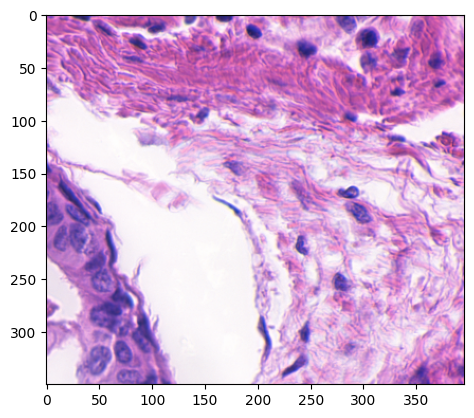

In [23]:
#Show here the image of the tissue
img = Image.open('img_441.png')
plt.imshow(img)

In [19]:
#Let's impose a custom dataset CustomDataset class is designed to be flexible,
#To provide filenames and labels explicitly or read them from a CSV file because It supports image transformations for data augmentation

class CustomDataset(Dataset):
    def __init__(self, image_directory, labels_file_path, transform=None, provided_filenames=None, provided_labels=None):
        """
        CustomDataset builder section.
        Parameters considered in the function:
        - transform (callable, optional): Optional transform to be applied to the images.
        - provided_filenames (list, optional): List of filenames corresponding to the images.
        - provided_labels (list, optional): List of labels corresponding to the images.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labels_file_path)
        self.transform = transform

        # Use provided filenames and labels if available
        if provided_filenames is not None and provided_labels is not None:
            self.filenames = provided_filenames
            self.labels = provided_labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        The folowing part it gives the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.
        Parameters:
        - idx (int): Index of the item to retrieve.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        #Since, from literature, many machine learning models and image processing libraries expect images to be in RGB format for consistency.
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        #It return here a tuble with the image and its label
        return image, label

In [25]:
max_width = 0
max_height = 0
# Initialize variables to store the maximum width and height of the images.

for file_name in labeled_filenames:
    file_path = os.path.join(image_directory, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)
    # Iterate over the labeled_filenames and open each image using PIL.
    # Get the width and height of each image and update the maximum width and height if necessary.